# Argonne Lab Talk 

Computations and figures for a semnar at Argonne Lab

presented on Thursday, May 18, 2023, [slides here](https://speakerdeck.com/fjhickernell/low-discrepancy-at-argonne-2023-may)

To run this notebook you need to pip install

    • qmcpy
    • sympy
    • docker

## Import the necessary packages and set up plotting routines

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as Nintegrate
import qmcpy as qp
from sympy import * #so that we can do symbolic integration
import time  #timing routines
import warnings  #to suppress warnings when needed
import pickle  #write output to a file and load it back in
from copy import deepcopy
from matplotlib.patches import Polygon

np.set_printoptions(threshold=10)

plt.rc('font', size=16)  #set defaults so that the plots are readable
plt.rc('font', serif = "Computer Modern Roman")
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb,bm}')
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=16)

#a helpful plotting method to show increasing numbers of points
def plot_successive_points(distrib,ld_name,first_n=64,n_cols=1,
                           pt_clr=['tab:blue', 'tab:orange', 'k', 'tab:cyan', 'tab:purple', 'tab:orange'],
                           xlim=[0,1],ylim=[0,1],ntitle=True,titleText='',
                          coordlist=[[0,1]],nrep=1):
  fig,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(5*n_cols,5.5))
  if n_cols==1: ax = [ax]
  last_n = first_n*(2**n_cols)
  if isinstance(distrib, list):
    nrep = len(distrib)
  else:
    nrep = 1
  if nrep==1: points = distrib.gen_samples(n=last_n)
  ncoord = len(coordlist)
  for i in range(n_cols):
    n = first_n
    nstart = 0
    if nrep > 1:
      points = distrib[i].gen_samples(n=last_n)
      ax[i].scatter(points[nstart:n,0],points[nstart:n,1],color=pt_clr[0])
      ax[i].set_xlim(xlim); ax[i].set_xticks(xlim); ax[i].set_xlabel('$x_{i,'+str(coordlist[0][0]+1)+'}$')
      ax[i].set_ylim(ylim); ax[i].set_yticks(ylim); ax[i].set_ylabel('$x_{i,'+str(coordlist[0][1]+1)+'}$')
    elif ncoord >1:
      ax[i].scatter(points[nstart:n,coordlist[i][0]],points[nstart:n,coordlist[i][1]],color=pt_clr[0])
      ax[i].set_xlim(xlim); ax[i].set_xticks(xlim); ax[i].set_xlabel('$x_{i,'+str(coordlist[i][0]+1)+'}$')
      ax[i].set_ylim(ylim); ax[i].set_yticks(ylim); ax[i].set_ylabel('$x_{i,'+str(coordlist[i][1]+1)+'}$')
    else:
      for j in range(i+1):
        n = first_n*(2**j)
        ax[i].scatter(points[nstart:n,0],points[nstart:n,1],color=pt_clr[j])
        nstart = n
        if ntitle == True:
          ax[i].set_title('n = %d'%n)
        else:
          ax[i].set_title(titleText)
        ax[i].set_xlabel('$x_{i,'+str(coordlist[0][0]+1)+'}$')
        ax[i].set_ylabel('$x_{i,'+str(coordlist[0][1]+1)+'}$')
    ax[i].set_xlim(xlim); ax[i].set_xticks(xlim)
    ax[i].set_ylim(ylim); ax[i].set_yticks(ylim)
    ax[i].set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
  if ld_name != "":
    fig.suptitle('%s Points'%ld_name, y=0.87)
  return fig
print('QMCPy Version',qp.__version__)


QMCPy Version 1.4


### Set the path to save the figures here

In [2]:
figpath = '' #this path sends the figures to the directory that you want

## Trapezoidal rule and its error

### Define test function

In [3]:
x = Symbol('x')                       #do some symbolic computation 
fsim = 30*x*exp(-5*x)                 #our test function
intf = N(integrate(fsim, (x, 0, 1)))  #and its integral
print(intf)

1.15148678160658


### Plot test function and trapezoidal rule

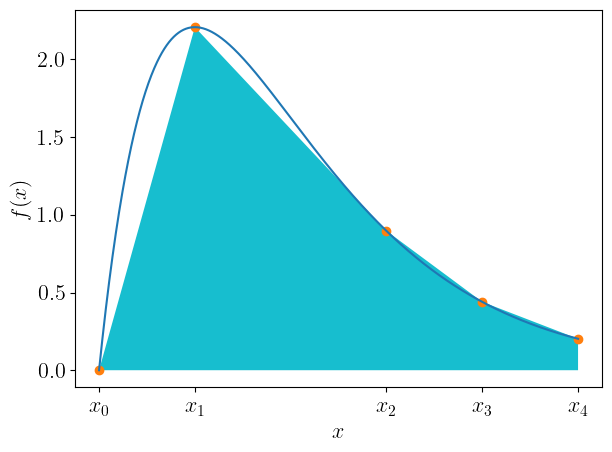

In [4]:
f = lambdify(x,fsim)                     #make it a numeric function
xnodes = np.array([0, 0.2, 0.6, 0.8, 1]) #choose nodes to apply the trapezoidla rule
fnodes = f(xnodes)                       #function values at those nodes
xplot = np.linspace(0, 1, 1000)          #nodes for polotting our function
fig,ax = plt.subplots()
xfpatch = np.append(np.transpose(np.array([xnodes, fnodes])),[[1,0]],axis=0)  #the trapezoidal rule approximation
ax.add_patch(Polygon(xfpatch,facecolor='tab:cyan'))  #plot the trapezoidal rule
plt.plot(xplot, f(xplot), color='tab:blue')          #and the function
plt.scatter(xnodes, fnodes, color='tab:orange')     #and the nodes
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
xlabels = []
for i in range(xnodes.size): xlabels.append(f'$x_{i}$')    
ax.set_xticks(xnodes,labels = xlabels) 
plt.tight_layout() 
fig.savefig(figpath+'traprule.eps',format='eps',bbox_inches='tight')

### Compute trapezoidal rule and its error

In [5]:
xdiff = np.diff(xnodes)
trap_rule = np.sum((fnodes[:-1]*xdiff+fnodes[1:]*xdiff)/2)
err_trap = intf - trap_rule 
print(err_trap)

0.112324710648342


### Compute elements of the trio identity

150*(5*x - 2)*exp(-5*x)
True
[0.150522653770521, 0.019999999999999997, 37.3115633543065]


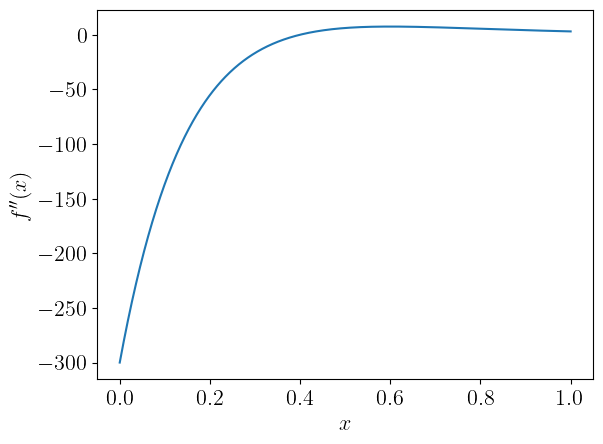

In [6]:
discrepancy = np.max(xdiff**2)/8                          #quality of the nodes
f2diffsim = diff(fsim,x,2)
print(f2diffsim)
f2diff = lambdify(x,f2diffsim) 
fig,ax = plt.subplots()
plt.plot(xplot, f2diff(xplot), color='tab:blue')
ax.set_xlabel('$x$')
ax.set_ylabel("$f''(x)$");
variation = N(integrate(abs(f2diffsim), (x, 0, 1)))   #roughness of the integrand
Nvariation = Nintegrate.quad(lambda x: abs(f2diff(x)),0,1,epsabs = 1e-14)  #checking whether the symbolic integration is correct
print(abs(Nvariation[0]-variation) <= 1e-10)          #do the symbolic and numerical integration methods agree
confound = err_trap/(discrepancy*variation)           #how unlucky the integrand is, should be between -1 and +1
print([confound,discrepancy, variation])              #the trapezoidal rule error is the product of these three numbers
fig.savefig(figpath+'traprulef2.eps',format='eps',bbox_inches='tight')

## Plots of IID and Low Discrepancy (LD) Points
These plots show how LD points fill space better than IID points
### Lattice points first

[[0.44914076 0.9858865  0.19756351 ... 0.99344309 0.82876649 0.29123131]
 [0.94914076 0.4858865  0.69756351 ... 0.49344309 0.32876649 0.79123131]
 [0.69914076 0.7358865  0.94756351 ... 0.74344309 0.57876649 0.54123131]
 ...
 [0.18351576 0.0640115  0.40068851 ... 0.38406809 0.90689149 0.77560631]
 [0.93351576 0.3140115  0.65068851 ... 0.63406809 0.15689149 0.52560631]
 [0.43351576 0.8140115  0.15068851 ... 0.13406809 0.65689149 0.02560631]]


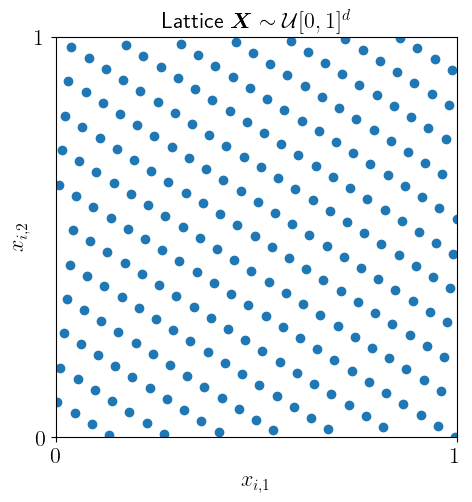

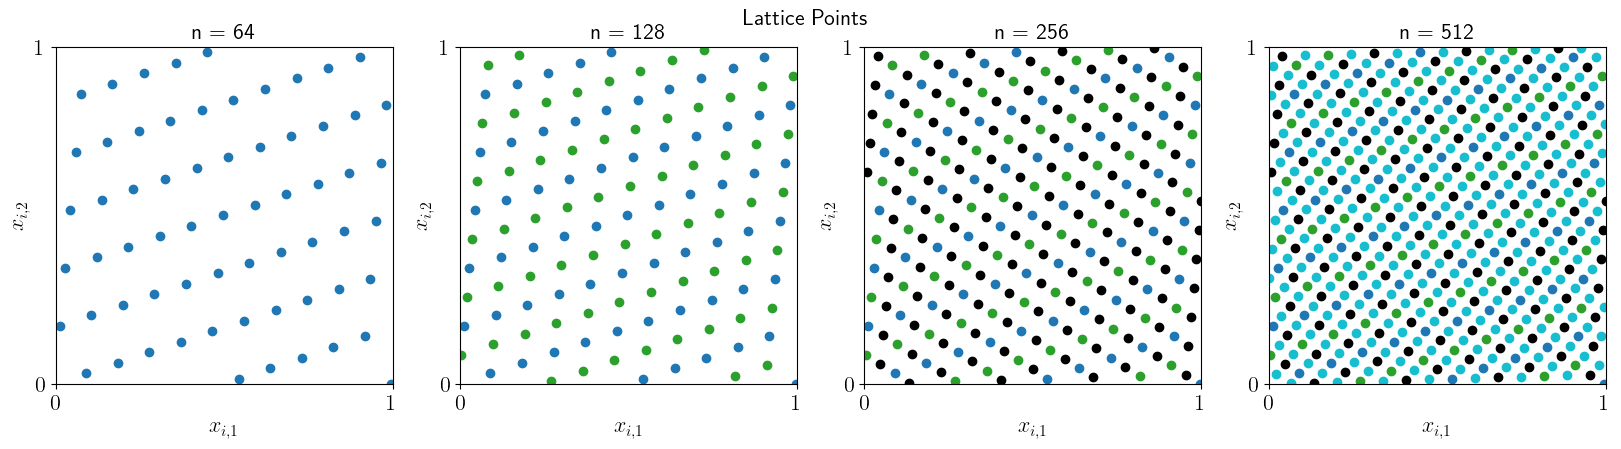

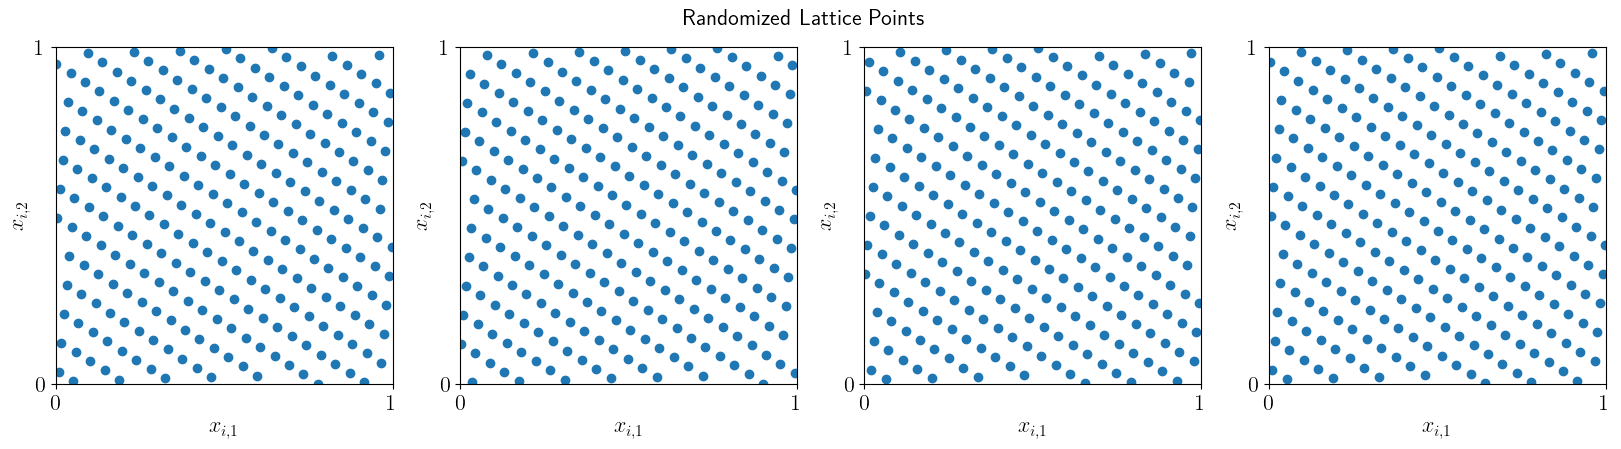

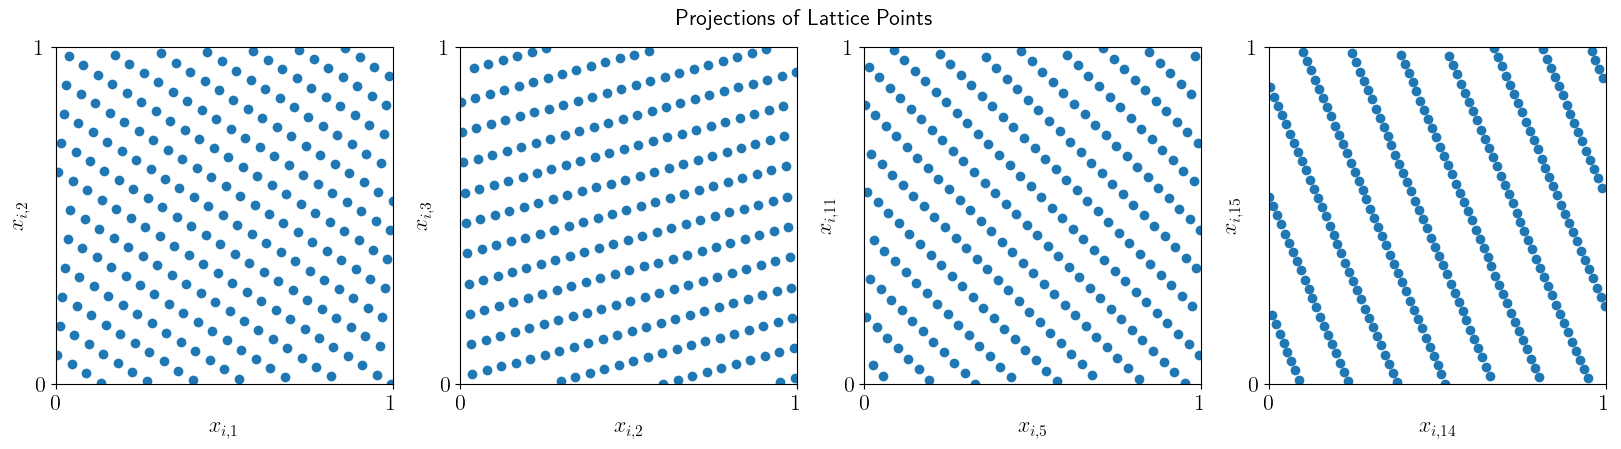

In [7]:
d = 15 #dimension
n = 64 #number of points
nrand = 4 #number of randomizations
coordlist=[[0,1],[1,2],[4,10],[13,14]]
ld = qp.Lattice(d) #define the generator
xpts = ld.gen_samples(n) #generate points
print(xpts)
fig = plot_successive_points(ld,'',first_n=4*n,n_cols=1,ntitle=False,titleText=r'Lattice $\boldsymbol{X} \sim \mathcal{U}[0,1]^d$')
plt.tight_layout() 
fig.savefig(figpath+'latticeptssingle.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Lattice',first_n=n,n_cols=4)
fig.savefig(figpath+'latticeptsseq.eps',format='eps',bbox_inches='tight')
ldrand = ld.spawn(nrand) #randomize
fig = plot_successive_points(ldrand,'Randomized Lattice',first_n=4*n,n_cols=nrand)
fig.savefig(figpath+'latticeptsrand.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Projections of Lattice',first_n=4*n,n_cols=nrand,coordlist=coordlist)
fig.savefig(figpath+'latticeptsproj.eps',format='eps',bbox_inches='tight')

### Next Sobol' points

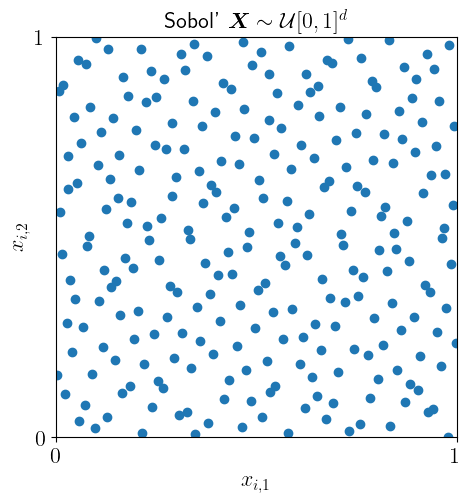

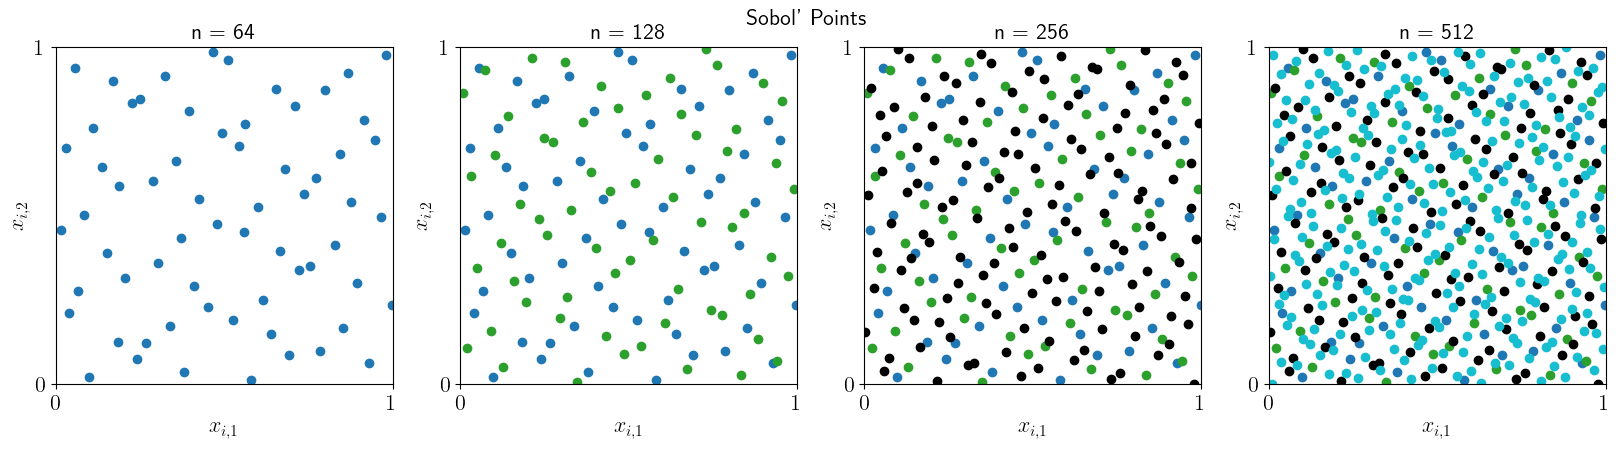

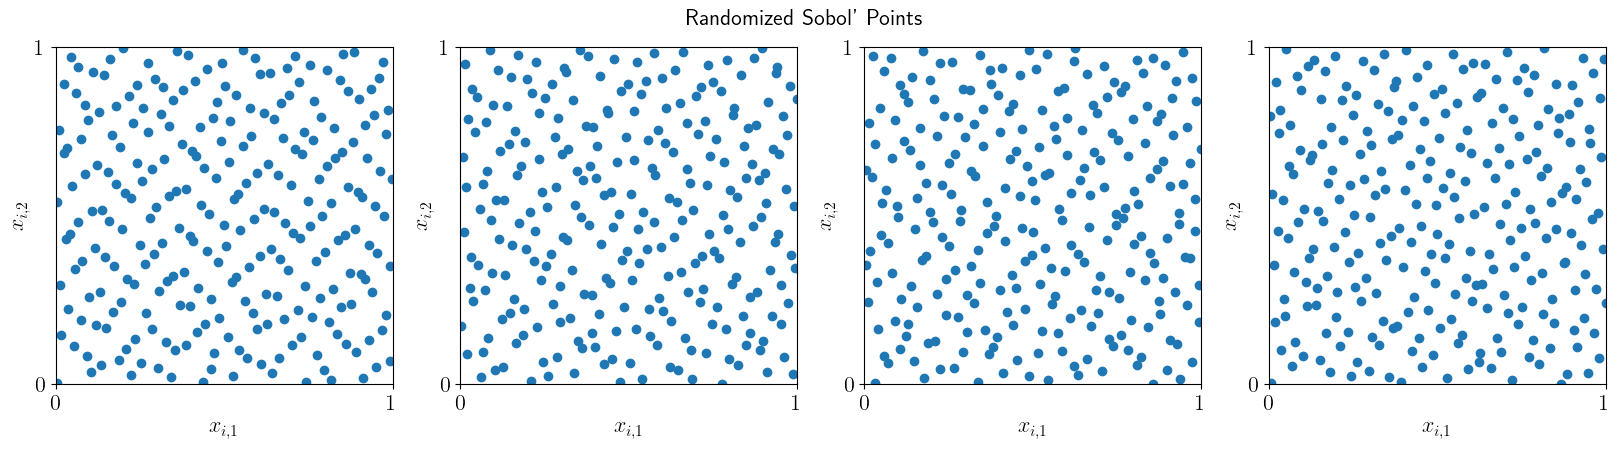

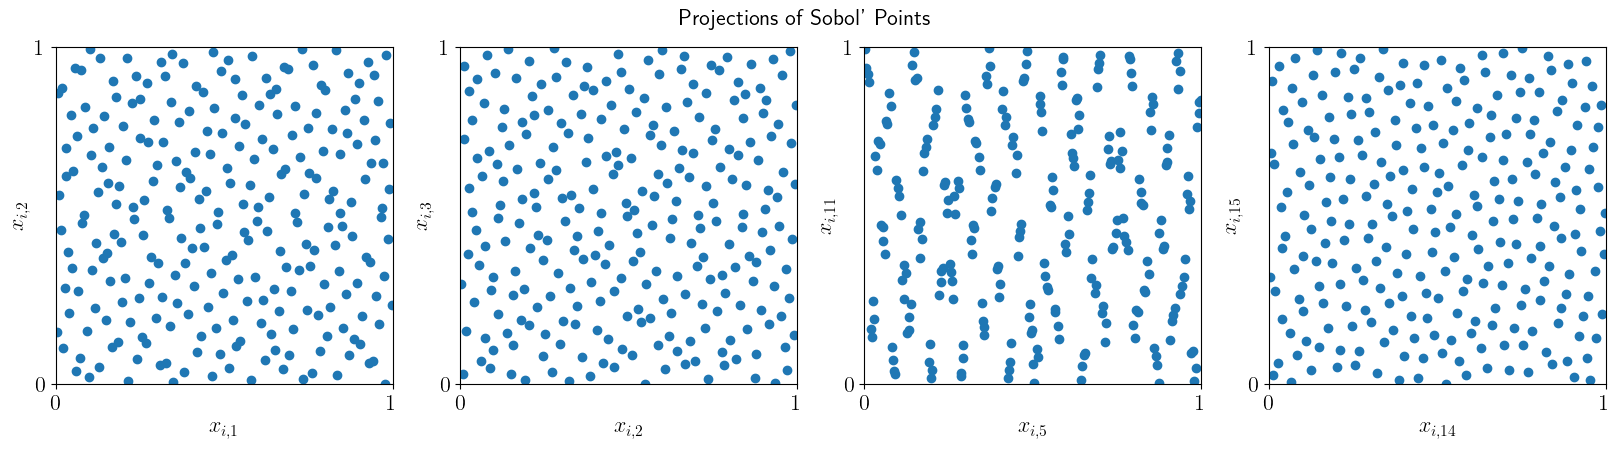

In [8]:
ld = qp.Sobol(d,seed=47) #define the generator
xpts_Sobol = ld.gen_samples(n) #generate points
fig = plot_successive_points(ld,'',first_n=4*n,n_cols=1,ntitle=False,titleText=r"Sobol' $\boldsymbol{X} \sim \mathcal{U}[0,1]^d$")
plt.tight_layout() 
fig.savefig(figpath+'sobolptssingle.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Sobol\'',first_n=n,n_cols=4)
fig.savefig(figpath+'sobolptsseq.eps',format='eps',bbox_inches='tight')
ldrand = ld.spawn(nrand) #randomize
fig = plot_successive_points(ldrand,'Randomized Sobol\'',first_n=4*n,n_cols=nrand)
fig.savefig(figpath+'sobolptsrand.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Projections of Sobol\'',first_n=4*n,n_cols=nrand,coordlist=coordlist)
fig.savefig(figpath+'sobolptsproj.eps',format='eps',bbox_inches='tight')

### Also Halton points

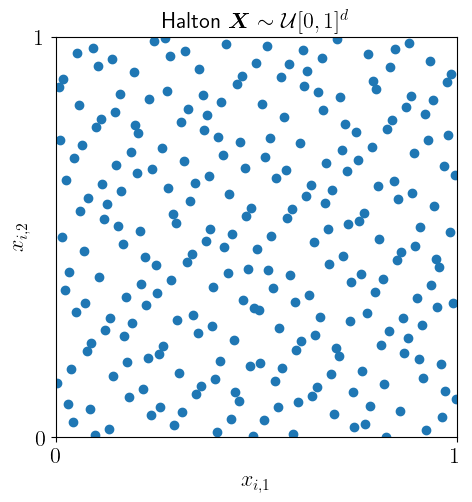

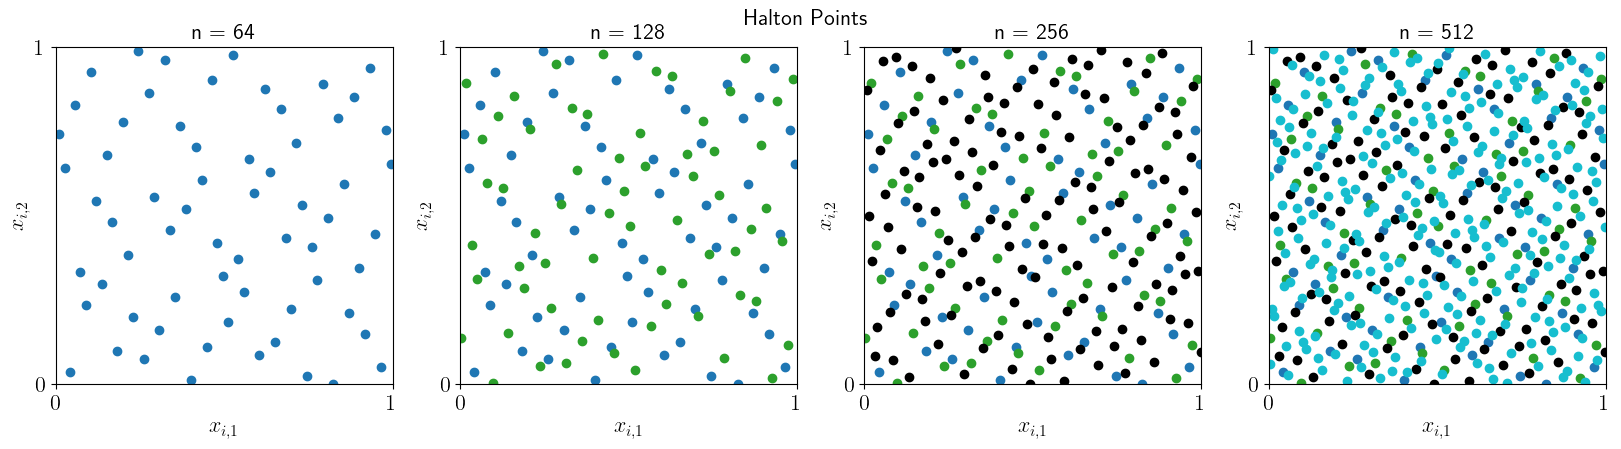

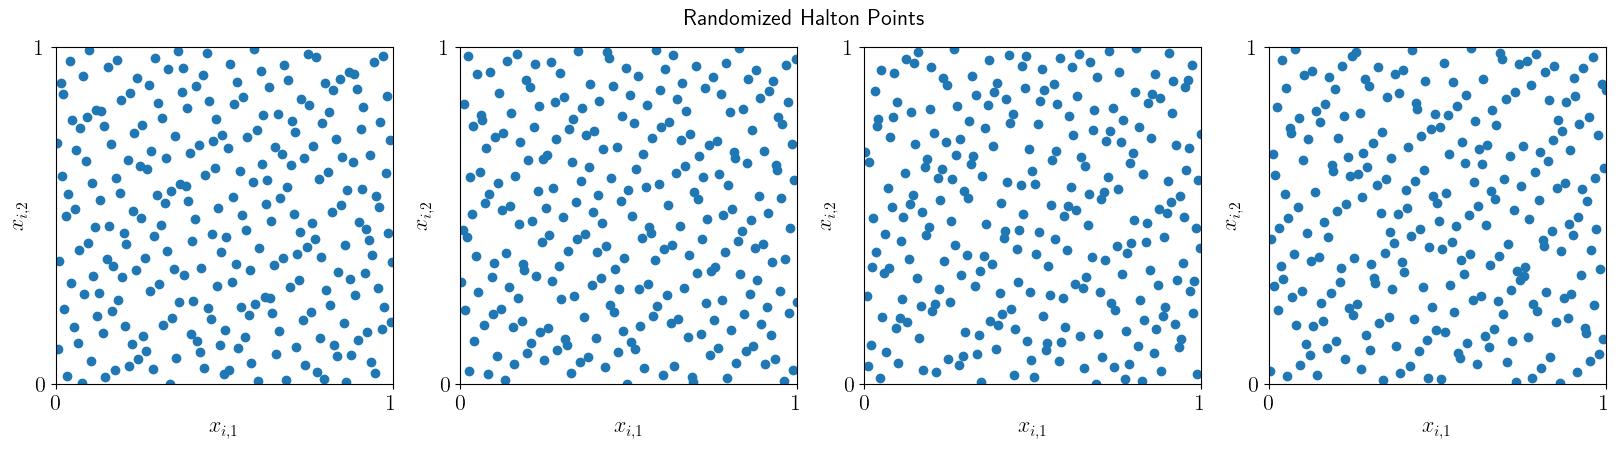

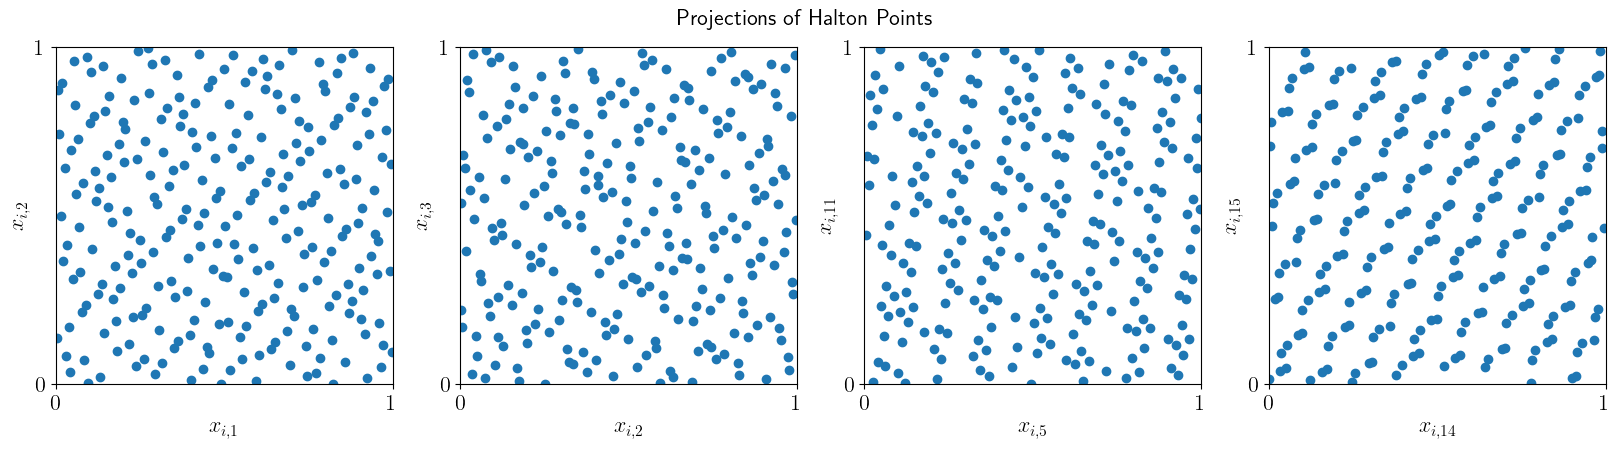

In [9]:
ld = qp.Halton(d) #define the generator
xpts_Halton = ld.gen_samples(n) #generate points
fig = plot_successive_points(ld,'',first_n=4*n,n_cols=1,ntitle=False,titleText=r'Halton $\boldsymbol{X} \sim \mathcal{U}[0,1]^d$')
plt.tight_layout() 
fig.savefig(figpath+'haltonptssingle.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Halton',first_n=n,n_cols=4)
fig.savefig(figpath+'haltonptsseq.eps',format='eps',bbox_inches='tight')
ldrand = ld.spawn(nrand) #randomize
fig = plot_successive_points(ldrand,'Randomized Halton',first_n=4*n,n_cols=nrand)
fig.savefig(figpath+'haltonptsrand.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Projections of Halton',first_n=4*n,n_cols=nrand,coordlist=coordlist)
fig.savefig(figpath+'haltonptsproj.eps',format='eps',bbox_inches='tight')

### Compare to IID

Note that there are more gaps and clusters

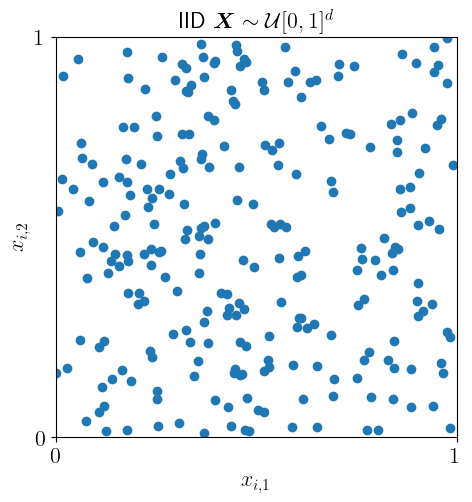

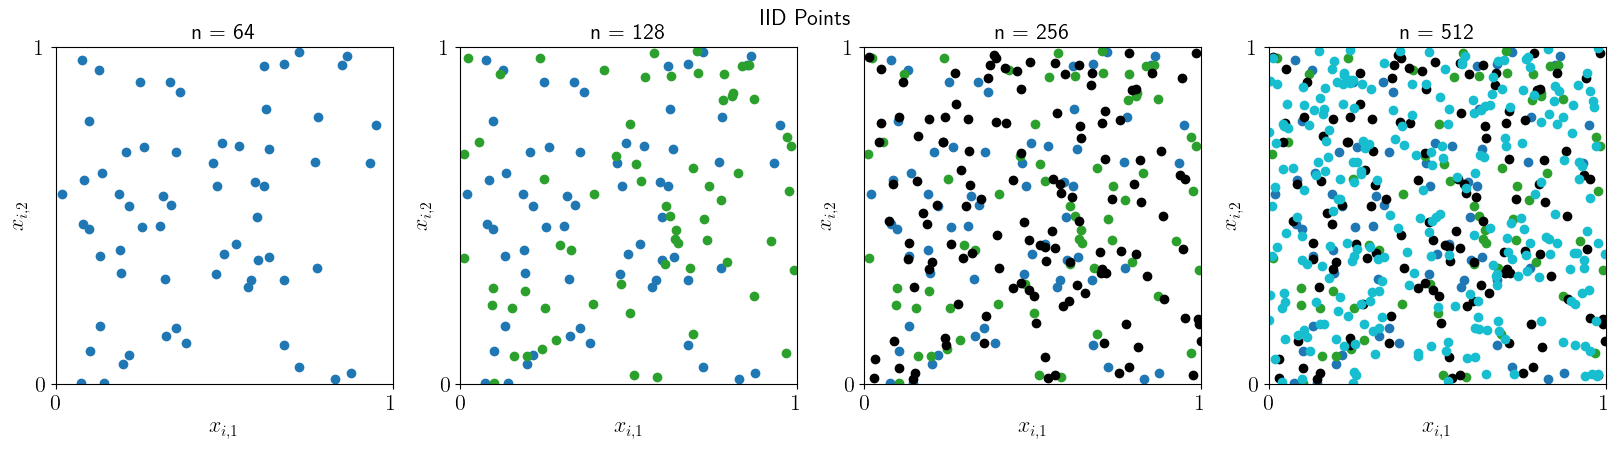

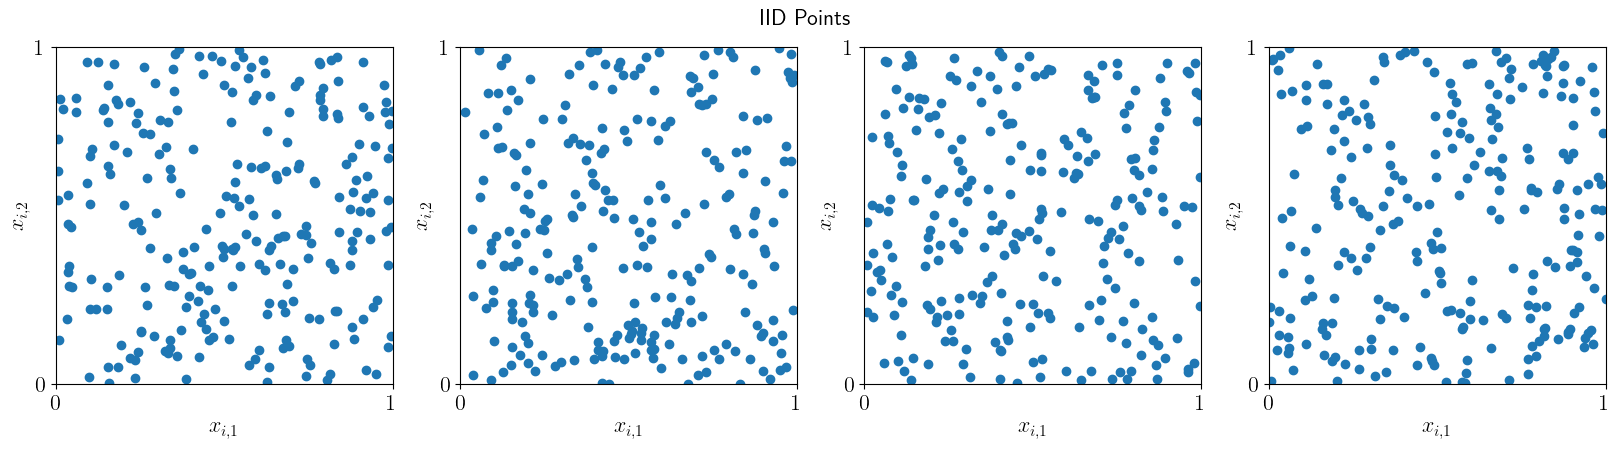

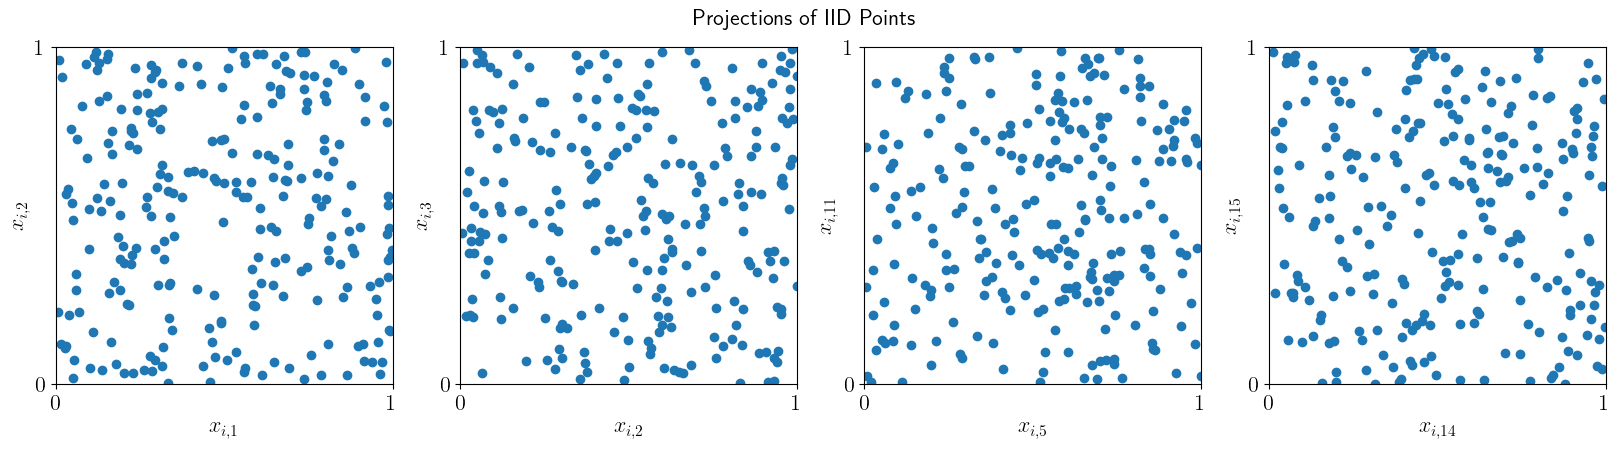

In [10]:
iid = qp.IIDStdUniform(d) #define the generator
xpts = ld.gen_samples(n) #generate points
xpts
fig = plot_successive_points(iid,'',first_n=4*n,n_cols=1,ntitle=False,titleText=r'IID $\boldsymbol{X}\sim\mathcal{U}[0,1]^d$')
plt.tight_layout() 
fig.savefig(figpath+'iidptssingle.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(iid,'IID',first_n=n,n_cols=4)
fig.savefig(figpath+'iidptsseq.eps',format='eps',bbox_inches='tight')
iidrand = iid.spawn(nrand) #randomize
fig = plot_successive_points(iidrand,'IID',first_n=4*n,n_cols=nrand)
fig.savefig(figpath+'iidptsrand.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(iid,'Projections of IID',first_n=4*n,n_cols=nrand,coordlist=coordlist)
fig.savefig(figpath+'iidptsproj.eps',format='eps',bbox_inches='tight')

## Beam Example Figures

Using computations done below

### Plot the time and sample size required to solve for the deflection of the end point using IID and low discrepancy 

[1037.12106673]


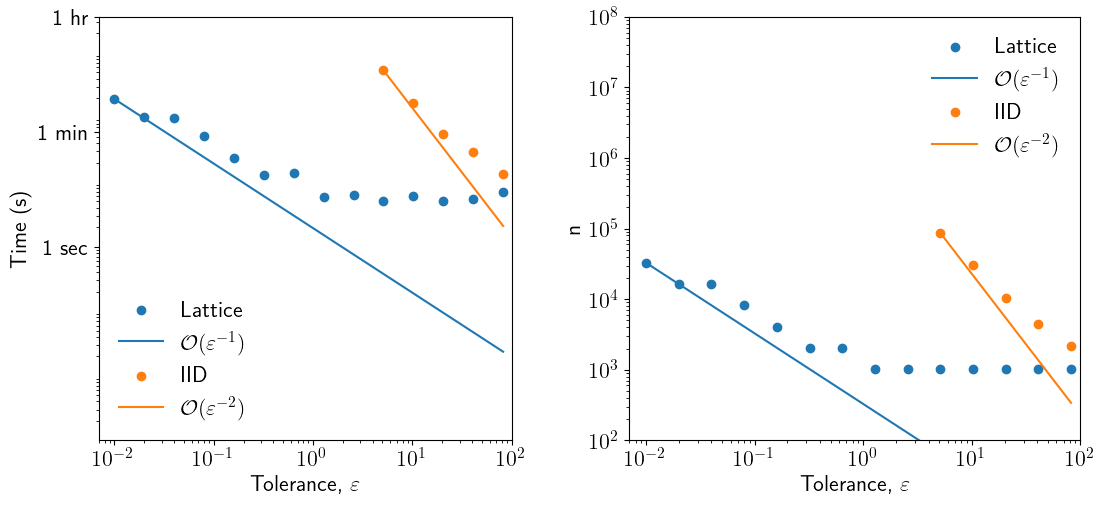

In [5]:
with open(figpath+'iid_ld.pkl','rb') as myfile: tol_vec,n_tol,ii_iid,ld_time,ld_n,iid_time,iid_n,best_solution_i = pickle.load(myfile)
print(best_solution_i)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5.5))
ax[0].scatter(tol_vec[0:n_tol],ld_time[0:n_tol],color='tab:blue'); 
ax[0].plot(tol_vec[0:n_tol],[(ld_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:blue')
ax[0].scatter(tol_vec[ii_iid:n_tol],iid_time[ii_iid:n_tol],color='tab:orange'); 
ax[0].plot(tol_vec[ii_iid:n_tol],[(iid_time[ii_iid]*(tol_vec[ii_iid]**2))/(tol_vec[jj]**2) for jj in range(ii_iid,n_tol)],color='tab:orange')
ax[0].set_ylim([0.001,1000]); ax[0].set_ylabel('Time (s)')
ax[1].scatter(tol_vec[0:n_tol],ld_n[0:n_tol],color='tab:blue'); 
ax[1].plot(tol_vec[0:n_tol],[(ld_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:blue')
ax[1].scatter(tol_vec[ii_iid:n_tol],iid_n[ii_iid:n_tol],color='tab:orange'); 
ax[1].plot(tol_vec[ii_iid:n_tol],[(iid_n[ii_iid]*(tol_vec[ii_iid]**2))/(tol_vec[jj]**2) for jj in range(ii_iid,n_tol)],color='tab:orange')
ax[1].set_ylim([1e2,1e8]); ax[1].set_ylabel('n')
for ii in range(2):
  ax[ii].set_xlim([0.007,100]); ax[ii].set_xlabel('Tolerance, '+r'$\varepsilon$')
  ax[ii].set_xscale('log'); ax[ii].set_yscale('log')
  ax[ii].legend(['Lattice',r'$\mathcal{O}(\varepsilon^{-1})$','IID',r'$\mathcal{O}(\varepsilon^{-2})$'],frameon=False)
  ax[ii].set_aspect(0.65)
ax[0].set_yticks([1, 60, 3600], labels = ['1 sec', '1 min', '1 hr'])    
fig.savefig(figpath+'iidldbeam.eps',format='eps',bbox_inches='tight')

### Plot the time and sample size required to solve for the deflection of the whole beam using low discrepancy with and without parallel

[1037.12106673]


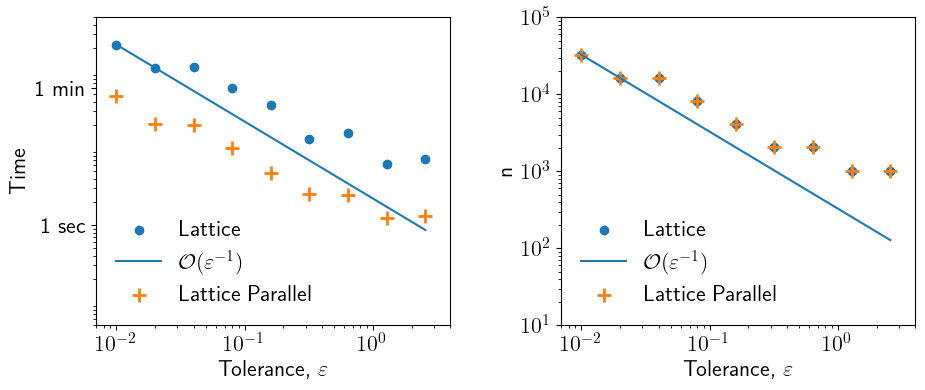

In [12]:
with open(figpath+'ld_parallel.pkl','rb') as myfile: tol_vec,n_tol,ld_time,ld_n,ld_p_time,ld_p_n,best_solution = pickle.load(myfile)
print(best_solution_i)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(11,4))
ax[0].scatter(tol_vec[0:n_tol],ld_time[0:n_tol],color='tab:blue'); 
ax[0].plot(tol_vec[0:n_tol],[(ld_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:blue')
ax[0].scatter(tol_vec[0:n_tol],ld_p_time[0:n_tol],color='tab:orange',marker = '+',s=100,linewidths=2); 
#ax[0].plot(tol_vec[0:n_tol],[(ld_p_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:orange')
ax[0].set_ylim([0.05,500]); ax[0].set_ylabel('Time')
ax[1].scatter(tol_vec[0:n_tol],ld_n[0:n_tol],color='tab:blue'); 
ax[1].plot(tol_vec[0:n_tol],[(ld_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:blue')
ax[1].scatter(tol_vec[0:n_tol],ld_p_n[0:n_tol],color='tab:orange',marker = '+',s=100,linewidths=2); 
#ax[1].plot(tol_vec[0:n_tol],[(ld_p_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:orange')
ax[1].set_ylim([10,1e5]); ax[1].set_ylabel('n')
for ii in range(2):
  ax[ii].set_xlim([0.007,4]); ax[ii].set_xlabel('Tolerance, '+r'$\varepsilon$')
  ax[ii].set_xscale('log'); ax[ii].set_yscale('log')
  ax[ii].legend(['Lattice',r'$\mathcal{O}(\varepsilon^{-1})$','Lattice Parallel',r'$\mathcal{O}(\varepsilon^{-1})$'],frameon=False)
  ax[ii].set_aspect(0.6)
ax[0].set_yticks([1, 60], labels = ['1 sec', '1 min'])
fig.savefig(figpath+'ldparallelbeam.eps',format='eps',bbox_inches='tight')

### Plot of beam solution

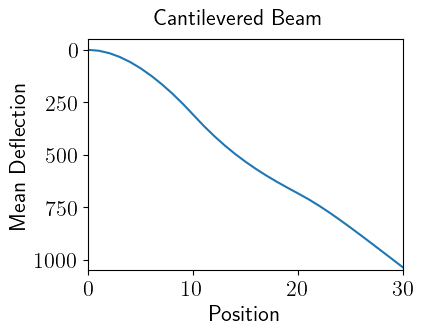

In [13]:
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(best_solution,'-')
ax.set_xlim([0,len(best_solution)-1]); ax.set_xlabel('Position')
ax.set_ylim([1050,-50]);  ax.set_ylabel('Mean Deflection');
ax.set_aspect(0.02)
fig.suptitle('Cantilevered Beam')
fig.savefig(figpath+'cantileveredbeamwords.eps',format='eps',bbox_inches='tight')

*Below is long-running code, that we rarely wish to run*

## Bayesian Logistic Regression
This is an example where the solution is ratio of two integrals

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data',header=None)
df.columns = ['Age','1900 Year','Axillary Nodes','Survival Status']
df.loc[df['Survival Status']==2,'Survival Status'] = 0
x,y = df[['Age','1900 Year','Axillary Nodes']],df['Survival Status']
xt,xv,yt,yv = train_test_split(x,y,test_size=.33,random_state=7)

In [15]:
print(df.head(),'\n')
print(df[['Age','1900 Year','Axillary Nodes']].describe(),'\n')
print(df['Survival Status'].astype(str).describe())
print('\ntrain samples: %d test samples: %d\n'%(len(xt),len(xv)))
print('train positives %d   train negatives: %d'%(np.sum(yt==1),np.sum(yt==0)))
print(' test positives %d    test negatives: %d'%(np.sum(yv==1),np.sum(yv==0)))
xt.head()

   Age  1900 Year  Axillary Nodes  Survival Status
0   30         64               1                1
1   30         62               3                1
2   30         65               0                1
3   31         59               2                1
4   31         65               4                1 

              Age   1900 Year  Axillary Nodes
count  306.000000  306.000000      306.000000
mean    52.457516   62.852941        4.026144
std     10.803452    3.249405        7.189654
min     30.000000   58.000000        0.000000
25%     44.000000   60.000000        0.000000
50%     52.000000   63.000000        1.000000
75%     60.750000   65.750000        4.000000
max     83.000000   69.000000       52.000000 

count     306
unique      2
top         1
freq      225
Name: Survival Status, dtype: object

train samples: 205 test samples: 101

train positives 151   train negatives: 54
 test positives 74    test negatives: 27


,Age,1900 Year,Axillary Nodes
46,41,58,0
199,57,64,1
115,49,64,10
128,50,61,0
249,63,63,0


In [16]:
blr = qp.BayesianLRCoeffs(
    sampler = qp.DigitalNetB2(4,seed=7),
    feature_array = xt, # np.ndarray of shape (n,d-1)
    response_vector = yt, # np.ndarray of shape (n,)
    prior_mean = 0, # normal prior mean = (0,0,...,0)
    prior_covariance = 5) # normal prior covariance = 5I
qmc_sc = qp.CubQMCNetG(blr,
    abs_tol = .05,
    rel_tol = .5,
    error_fun = lambda s,abs_tols,rel_tols:
        np.minimum(abs_tols,np.abs(s)*rel_tols))
blr_coefs,blr_data = qmc_sc.integrate()
print(blr_data)
# LDTransformData (AccumulateData Object)
#     solution        [-0.004  0.13  -0.157  0.008]
#     comb_bound_low  [-0.006  0.092 -0.205  0.007]
#     comb_bound_high [-0.003  0.172 -0.109  0.012]
#     comb_flags      [ True  True  True  True]
#     n_total         2^(18)
#     n               [[  1024.   1024. 262144.   2048.]
#                     [  1024.   1024. 262144.   2048.]]
#     time_integrate  2.229

LDTransformData (AccumulateData Object)
    solution        [-0.004  0.13  -0.157  0.008]
    comb_bound_low  [-0.006  0.092 -0.205  0.007]
    comb_bound_high [-0.003  0.172 -0.109  0.012]
    comb_flags      [ True  True  True  True]
    n_total         2^(18)
    n               [[  1024.   1024. 262144.   2048.]
                    [  1024.   1024. 262144.   2048.]]
    time_integrate  1.904
CubQMCNetG (StoppingCriterion Object)
    abs_tol         0.050
    rel_tol         2^(-1)
    n_init          2^(10)
    n_max           2^(35)
BayesianLRCoeffs (Integrand Object)
Gaussian (TrueMeasure Object)
    mean            0
    covariance      5
    decomp_type     PCA
DigitalNetB2 (DiscreteDistribution Object)
    d               2^(2)
    dvec            [0 1 2 3]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()


In [17]:
from sklearn.linear_model import LogisticRegression
def metrics(y,yhat):
    y,yhat = np.array(y),np.array(yhat)
    tp = np.sum((y==1)*(yhat==1))
    tn = np.sum((y==0)*(yhat==0))
    fp = np.sum((y==0)*(yhat==1))
    fn = np.sum((y==1)*(yhat==0))
    accuracy = (tp+tn)/(len(y))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return [accuracy,precision,recall]

results = pd.DataFrame({name:[] for name in ['method','Age','1900 Year','Axillary Nodes','Intercept','Accuracy','Precision','Recall']})
for i,l1_ratio in enumerate([0,.5,1]):
    lr = LogisticRegression(random_state=7,penalty="elasticnet",solver='saga',l1_ratio=l1_ratio).fit(xt,yt)
    results.loc[i] = [r'Elastic-Net \lambda=%.1f'%l1_ratio]+lr.coef_.squeeze().tolist()+[lr.intercept_.item()]+metrics(yv,lr.predict(xv))

blr_predict = lambda x: 1/(1+np.exp(-np.array(x)@blr_coefs[:-1]-blr_coefs[-1]))>=.5
blr_train_accuracy = np.mean(blr_predict(xt)==yt)
blr_test_accuracy = np.mean(blr_predict(xv)==yv)
results.loc[len(results)] = ['Bayesian']+blr_coefs.squeeze().tolist()+metrics(yv,blr_predict(xv))

import warnings
warnings.simplefilter('ignore',FutureWarning)
results.set_index('method',inplace=True)
print(results.head())
#root: results.to_latex(root+'lr_table.tex',formatters={'%s'%tt:lambda v:'%.1f'%(100*v) for tt in ['accuracy','precision','recall']},float_format="%.2e")

                              Age  1900 Year  Axillary Nodes  Intercept  \
method                                                                    
Elastic-Net \lambda=0.0 -0.012279   0.034401       -0.115153   0.001990   
Elastic-Net \lambda=0.5 -0.012041   0.034170       -0.114770   0.002025   
Elastic-Net \lambda=1.0 -0.011803   0.033940       -0.114387   0.002061   
Bayesian                -0.004138   0.129921       -0.156901   0.008034   

                         Accuracy  Precision    Recall  
method                                                  
Elastic-Net \lambda=0.0  0.742574   0.766667  0.932432  
Elastic-Net \lambda=0.5  0.742574   0.766667  0.932432  
Elastic-Net \lambda=1.0  0.742574   0.766667  0.932432  
Bayesian                 0.742574   0.740000  1.000000  


## Asian Option

### Comparing PCA and Cholesky Decompositions
Note that the Cholesky decomposition might not even meet the error tolerance

In [6]:
option_parameters = {'volatility' : .2,
             'start_price' : 100,
             'strike_price' : 100,
             'interest_rate' : 0.05}
m_steps = 7
nsteps = np.zeros(m_steps,dtype=int)
pca_price = np.zeros(m_steps)
chol_price = np.zeros(m_steps)
pca_time = np.zeros(m_steps)
chol_time = np.zeros(m_steps)
abstol=1e-4
for level in range(m_steps):
    nsteps[level] = 2**level
    aco = qp.AsianOption(qp.Sobol(nsteps[level]), **option_parameters, decomp_type = "PCA")
    approx_solution, data = qp.CubQMCSobolG(aco, abs_tol=abstol).integrate()
    pca_price[level] = approx_solution
    pca_time[level] = data.time_integrate
    print("Asian Option true value (%d time steps): %.5f (to within %.0e) in %.2f seconds using PCA"%(nsteps[level], approx_solution, abstol, data.time_integrate))
    aco = qp.AsianOption(qp.Sobol(nsteps[level]), **option_parameters, decomp_type = "Cholesky")
    approx_solution, data = qp.CubQMCSobolG(aco, abs_tol=abstol).integrate()
    chol_price[level] = approx_solution
    chol_time[level] = data.time_integrate
    print("Asian Option true value (%d time steps): %.5f (to within %.0e) in %.2f seconds using Cholesky"%(nsteps[level], approx_solution, abstol, data.time_integrate))


Asian Option true value (1 time steps): 5.22530 (to within 1e-04) in 0.04 seconds using PCA
Asian Option true value (1 time steps): 5.22528 (to within 1e-04) in 0.04 seconds using Cholesky
Asian Option true value (2 time steps): 5.63591 (to within 1e-04) in 0.11 seconds using PCA
Asian Option true value (2 time steps): 5.63592 (to within 1e-04) in 0.41 seconds using Cholesky
Asian Option true value (4 time steps): 5.73170 (to within 1e-04) in 0.62 seconds using PCA
Asian Option true value (4 time steps): 5.73169 (to within 1e-04) in 1.19 seconds using Cholesky
Asian Option true value (8 time steps): 5.75529 (to within 1e-04) in 0.73 seconds using PCA
Asian Option true value (8 time steps): 5.75531 (to within 1e-04) in 5.20 seconds using Cholesky
Asian Option true value (16 time steps): 5.76112 (to within 1e-04) in 1.25 seconds using PCA
Asian Option true value (16 time steps): 5.76136 (to within 1e-04) in 14.70 seconds using Cholesky
Asian Option true value (32 time steps): 5.76265 (to

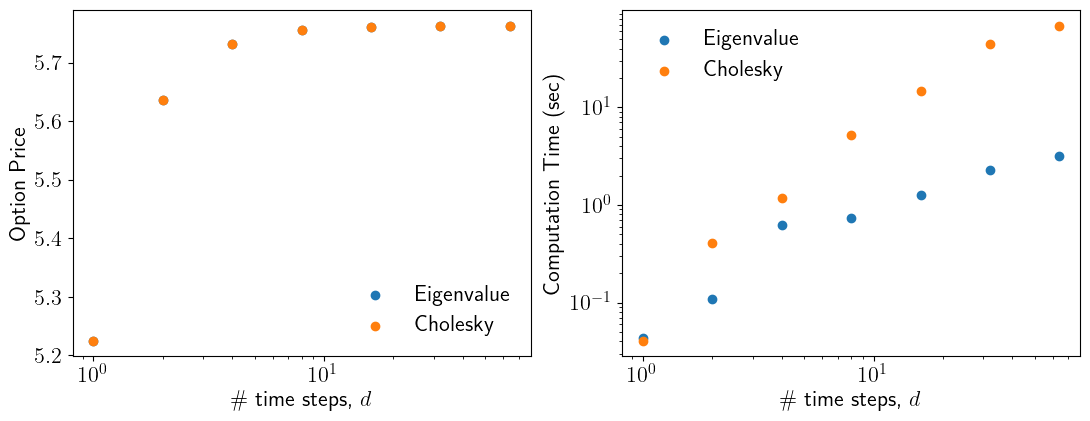

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,4.5))
ax[0].scatter(nsteps,pca_price,color='tab:blue'); 
ax[0].scatter(nsteps,chol_price,color='tab:orange'); 
ax[0].set_xscale('log')
ax[1].scatter(nsteps,pca_time,color='tab:blue'); 
ax[1].scatter(nsteps,chol_time,color='tab:orange'); 
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlabel(r'\# time steps, $d$');
ax[1].set_xlabel(r'\# time steps, $d$');
ax[0].set_ylabel(r'Option Price');
ax[1].set_ylabel(r'Computation Time (sec)');
ax[0].legend(['Eigenvalue','Cholesky'],frameon=False)
ax[1].legend(['Eigenvalue','Cholesky'],frameon=False)
fig.savefig(figpath+'optionpricing.eps',format='eps',bbox_inches='tight')

In [ ]:
qp.util.stop_notebook()

## Beam Example Computations
### Set up the problem using a docker container to solve the ODE

To run this, you need to be running the docker application, https://www.docker.com/products/docker-desktop/

In [ ]:
import umbridge #this is the connector
!docker run --name muqbp -d -it -p 4243:4243 linusseelinger/benchmark-muq-beam-propagation:latest #get beam example
d = 3 #dimension of the randomness
lb = 1 #lower bound on randomness
ub = 1.2 #upper bound on randomness
umbridge_config = {"d": d}
model = umbridge.HTTPModel('http://localhost:4243','forward') #this is the original model
outindex = -1 #choose last element of the vector of beam deflections
modeli = deepcopy(model) #and construct a model for just that deflection
modeli.get_output_sizes = lambda *args : [1]
modeli.get_output_sizes()
modeli.__call__ = lambda *args,**kwargs: [[model.__call__(*args,**kwargs)[0][outindex]]]

### First we compute the time required to solve for the deflection of the end point using IID and low discrepancy 

In [ ]:
ld = qp.Uniform(qp.Lattice(d,seed=7),lower_bound=lb,upper_bound=ub) #lattice points for this problem
ld_integ = qp.UMBridgeWrapper(ld,modeli,umbridge_config,parallel=False) #integrand
iid = qp.Uniform(qp.IIDStdUniform(d),lower_bound=lb,upper_bound=ub) #iid points for this problem
iid_integ = qp.UMBridgeWrapper(iid,modeli,umbridge_config,parallel=False) #integrand
tol = 0.01  #smallest tolerance

n_tol = 14  #number of different tolerances
ii_iid = 9  #make this larger to reduce the time required by not running all cases for IID
tol_vec = [tol*(2**ii) for ii in range(n_tol)]  #initialize vector of tolerances
ld_time = [0]*n_tol; ld_n = [0]*n_tol  #low discrepancy time and number of function values
iid_time = [0]*n_tol; iid_n = [0]*n_tol  #IID time and number of function values
print(f'\nCantilever Beam\n')
print('iteration ', end = '')
for ii in range(n_tol):
  solution, data = qp.CubQMCLatticeG(ld_integ, abs_tol = tol_vec[ii]).integrate()
  if ii == 0:
    best_solution_i = solution
  ld_time[ii] = data.time_integrate
  ld_n[ii] = data.n_total
  if ii >= ii_iid:
    solution, data = qp.CubMCG(iid_integ, abs_tol = tol_vec[ii]).integrate()
    iid_time[ii] = data.time_integrate
    iid_n[ii] = data.n_total
  print(ii, end = ' ')
with open(figpath+'iid_ld.pkl','wb') as myfile:pickle.dump([tol_vec,n_tol,ii_iid,ld_time,ld_n,iid_time,iid_n,best_solution_i],myfile)

### Next, we compute the time required to solve for the deflection of the whole beam using low discrepancy with and without parallel

In [ ]:
ld_integ = qp.UMBridgeWrapper(ld,model,umbridge_config,parallel=False) #integrand
ld_integ_p = qp.UMBridgeWrapper(ld,model,umbridge_config,parallel=8) #integrand with parallel processing

tol = 0.01
n_tol = 9  #number of different tolerances
tol_vec = [tol*(2**ii) for ii in range(n_tol)]  #initialize vector of tolerances
ld_time = [0]*n_tol; ld_n = [0]*n_tol  #low discrepancy time and number of function values
ld_p_time = [0]*n_tol; ld_p_n = [0]*n_tol  #low discrepancy time and number of function values with parallel
print(f'\nCantilever Beam\n')
print('iteration ', end = '')
for ii in range(n_tol):
  solution, data = qp.CubQMCLatticeG(ld_integ, abs_tol = tol_vec[ii]).integrate()
  if ii == 0:
    best_solution = solution
  ld_time[ii] = data.time_integrate
  ld_n[ii] = data.n_total
  solution, data = qp.CubQMCLatticeG(ld_integ_p, abs_tol = tol_vec[ii]).integrate()
  ld_p_time[ii] = data.time_integrate
  ld_p_n[ii] = data.n_total
  print(ii, end = ' ') 
with open(figpath+'ld_parallel.pkl','wb') as myfile:pickle.dump([tol_vec,n_tol,ld_time,ld_n,ld_p_time,ld_p_n,best_solution],myfile)

### Shut down docker

In [ ]:
!docker rm -f muqbp #shut down docker image